In [268]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
import cv2
import os
import glob
import time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from scipy.ndimage.measurements import label

%matplotlib inline
%config InlineBackend.figure_format='retina'

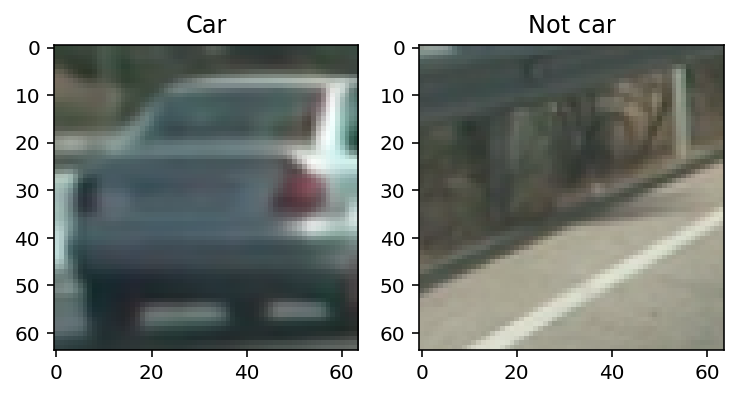

In [292]:
# Explore the data
image_car = './vehicles/GTI_Left/image0009.png'
image_notcar = './non-vehicles/GTI/image1000.png'

img_car = mpimg.imread(image_car)
img_notcar = mpimg.imread(image_notcar)
plt.subplot(121)
plt.imshow(img_car), plt.title('Car')

plt.subplot(122)
plt.imshow(img_notcar), plt.title('Not car')

plt.savefig('./output_images/car_not_car.png')

A single channel HOG feature length is 1764


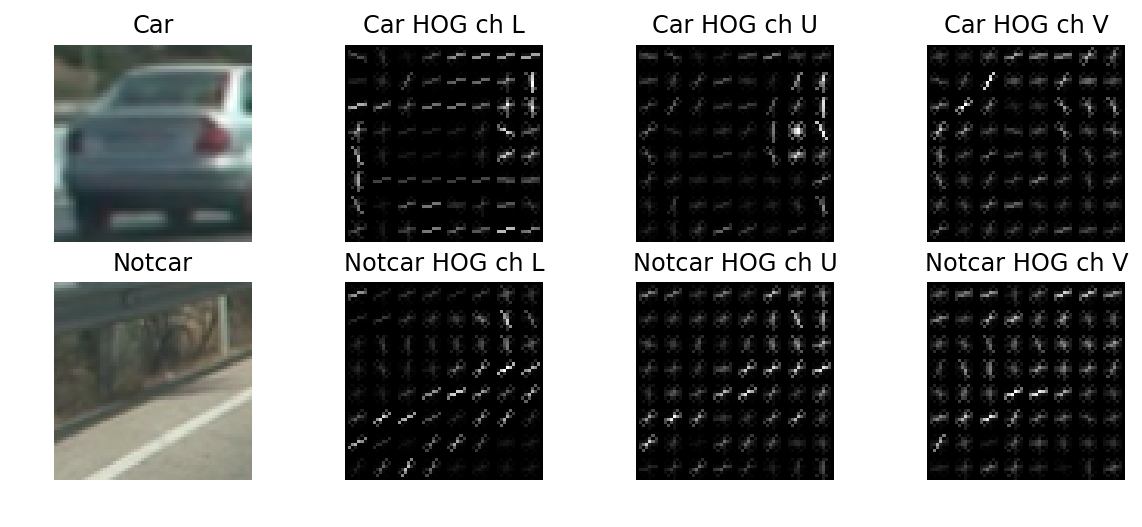

In [304]:
# Visualize HOG features with the same image as above
# Use LUV color space
car_LUV = cv2.cvtColor(np.copy(img_car), cv2.COLOR_RGB2LUV)
notcar_LUV = cv2.cvtColor(np.copy(img_notcar), cv2.COLOR_RGB2LUV)

# Store the channels in a list
channels = [car_LUV[:,:,0], car_LUV[:,:,1], car_LUV[:,:,2], notcar_LUV[:,:,0], notcar_LUV[:,:,1], notcar_LUV[:,:,2]]
# HOG feature
orient = 9
pixels_per_cell = 8
cells_per_block = 2

hog_images = []
for ch in channels:
    hog_vec, hog_image = hog(ch, orientations=orient, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                     cells_per_block=(cells_per_block, cells_per_block), visualise=True)
    hog_images.append(hog_image)

print('A single channel HOG feature length is', hog_vec.size)
fig = plt.figure(figsize=(10,4))
fig.add_subplot(241)
plt.imshow(img_car), plt.title('Car'), plt.axis('off')
for i in range(3):
    fig.add_subplot(2,4,i+2)
    plt.imshow(hog_images[i], cmap='gray'), plt.title('Car HOG ch {}'.format(['L', 'U', 'V'][i])), plt.axis('off')
    
fig.add_subplot(245)
plt.imshow(img_notcar), plt.title('Notcar'), plt.axis('off')
for i in range(3):
    fig.add_subplot(2,4,i+6)
    plt.imshow(hog_images[i+3], cmap='gray'), plt.title('Notcar HOG ch {}'.format(['L', 'U', 'V'][i])), plt.axis('off')

# fig.tight_layout()
fig.savefig('./output_images/hog_feature.png')

In [94]:
# Store vehicles and non vehicles data into lists
images_vehicles = glob.glob('./vehicles/*/*')
imgs_vehicles = [cv2.cvtColor(mpimg.imread(image), cv2.COLOR_RGB2LUV) for image in images_vehicles]

images_non_vehicles = glob.glob('./non-vehicles/*/*')
imgs_non_vehicles = [cv2.cvtColor(mpimg.imread(image), cv2.COLOR_RGB2LUV) for image in images_non_vehicles]

print('Number of vehicles data: {}'.format(len(imgs_vehicles)),
     '\nNumber of non-vehicles data: {}'.format(len(imgs_non_vehicles)))

Number of vehicles data: 8792 
Number of non-vehicles data: 8968


In [95]:
# Extract HOG features 
hog_feature_vecs = []
orient=9
pixs_per_cell= 8
cells_per_block=2
for img in imgs_vehicles+imgs_non_vehicles:
    ch1 = img[:,:,0]
    ch2 = img[:,:,1]
    ch3 = img[:,:,2]
    hog_feature1 = hog(ch1, orientations=orient, pixels_per_cell=(pixs_per_cell, pixs_per_cell), 
                         cells_per_block=(cells_per_block, cells_per_block), feature_vector=True)
    hog_feature2 = hog(ch2, orientations=orient, pixels_per_cell=(pixs_per_cell, pixs_per_cell), 
                         cells_per_block=(cells_per_block, cells_per_block), feature_vector=True)
    hog_feature3 = hog(ch3, orientations=orient, pixels_per_cell=(pixs_per_cell, pixs_per_cell), 
                         cells_per_block=(cells_per_block, cells_per_block), feature_vector=True)
    hog_feature_vec = np.hstack([hog_feature1, hog_feature2, hog_feature3])
    hog_feature_vecs.append(hog_feature_vec)
X = np.vstack(hog_feature_vecs)
y = np.hstack([np.ones(len(imgs_vehicles)), np.zeros(len(imgs_non_vehicles))])
print('The amount of data is: {}'.format(X.shape[0]),
     '\nThe feature length of the data is {}'.format(X.shape[1]))

The amount of data is: 17760 
The feature length of the data is 5292


In [96]:
# Normalize data

# Check the data type and range
print('The type of the training data is ', X.dtype,
     '\nThe range of the training data is ', (X.min(), X.max()))

# Normalize data with standard scaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Shuffle split data into training and testing
test_size=0.1
random_state=42
cv = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
train, test = next(cv.split(X,y))
X_train, X_test = X[train], X[test]
y_train, y_test = y[train], y[test]

The type of the training data is  float64 
The range of the training data is  (0.0, 0.99993263588047532)


In [100]:
# Build a classifier with SVM
N = 10 # number of data to show the prediction
# C =    # C parameter of SVM
clf = SVC()
t0 = time.time()
clf.fit(X_train, y_train)
t1 = time.time()
predictions = clf.predict(X_test)
accu = accuracy_score(predictions, y_test)
print('The accuracy is :{:.2f}'.format(accu),
     '\n Training takes {:.0f}s'.format(t1-t0))
print('Predictions:', predictions[:N], 
      '\nTrue values', y_test[:N])

The accuracy is :0.99 
 Training takes 339s
Predictions: [ 1.  0.  0.  1.  1.  1.  0.  1.  1.  0.] 
True values [ 1.  0.  0.  1.  1.  1.  0.  1.  1.  0.]


In [283]:
# Save classifier and scaler for later use
fl = 'clf.p'
with open(fl, 'wb') as f:
    pickle.dump((clf, scaler), f)

In [ ]:
# Experimentation
# Train a neural network classifier
# But in this project, I will use SVM for the moment
from keras.layers import Dense, Dropout
from keras.models import Sequential

In [ ]:
epochs = 50
batch_size=64
model = Sequential()

model.add(Dense(1000, activation='relu', input_dim=(X_train[0].shape[-1])))
# model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dropout(p=0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='sgd', loss='mse')
hist = model.fit(X_train, y_train, nb_epoch=epochs, batch_size=batch_size, validation_split=0.1)

In [ ]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Neural network classifer')
plt.savefig('./output_images/neural_network_classifier.png', dpi=300)

In [ ]:
N = 10
predictions = np.round(model.predict(X_test)).ravel()
accuracy=np.mean([predictions==y_test])
print('accuracy is {}'.format(accuracy))
print('Predictions', predictions[:N], 
      '\nTrue values', y_test[:N])

In [ ]:
test_image = './test_images/test1.jpg'
test_img = mpimg.imread(test_image)

orient=9
pixs_per_cell= 8
cells_per_block=2
gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
hog= hog(gray, orientations=orient, pixels_per_cell=(pixs_per_cell, pixs_per_cell),
         cells_per_block=(cells_per_block, cells_per_block), feature_vector=False)
hog.shape

In [ ]:
clf, scaler = pickle.load(open('clf.p', 'rb'))

In [238]:
time_stamps = []
from numba import jit
@jit
def find_cars(img, window_size, clf, scaler, orient, pixs_per_cell, cells_per_block, y_start_stop=[None, None], 
              default_win_size=64, cells_per_step=2):
    '''
    Extract HOG features and find the cars 
    '''
    # Get the height and width of the image for later reference
    h, w = img.shape[:2]
    # Make a copy to later draw bounding boxes 
    draw_img = np.copy(img)
    # Create a blank canvas to later draw heatmap with detected cars
    heatmap = np.zeros((h, w))
    # Convert the data type to float and change the range(0,1) as the training data
    img = img.astype(np.float32)/255
    # Convert image to HSV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    # Set y_start to zero and y_stop to h if not provided
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if y_start_stop[1] is None:
        y_start_stop[1] = h
    
    
    t0 = time.time()
    ystart, ystop = y_start_stop

    # Get the area of interest 
    # My computer takes forever to search the whole width of the image for cars, as well as my AWS ec2
    # So the function only searchs the right half of the image
    xstart, xstop = 820, 1280
    area_to_search = img[ystart:ystop, xstart:xstop]
    imshape = area_to_search.shape
    # Calculate the scale relative to the default win_size and scale the area of interest
    scale = window_size/default_win_size
    if scale != 1:
        area_to_search = cv2.resize(area_to_search, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    t1 = time.time()
#     print('Slicing search area uses {}s'.format(t1-t0))
    time_stamps.append(t1-t0)
    # Compute the HOG features for the whole area of interest
    ch1, ch2, ch3 = area_to_search[:,:,0], area_to_search[:,:,1], area_to_search[:,:,2]
    HOG1 = hog(ch1, orientations = orient, pixels_per_cell=(pixs_per_cell, pixs_per_cell),
             cells_per_block=(cells_per_block, cells_per_block), feature_vector=False)
    HOG2 = hog(ch2, orientations = orient, pixels_per_cell=(pixs_per_cell, pixs_per_cell),
             cells_per_block=(cells_per_block, cells_per_block), feature_vector=False)
    HOG3 = hog(ch3, orientations = orient, pixels_per_cell=(pixs_per_cell, pixs_per_cell),
             cells_per_block=(cells_per_block, cells_per_block), feature_vector=False)
    t2 = time.time()
#     print('Getting HOG features uses {}s'.format(t2-t1))
    time_stamps.append(t2-t1)
#         print('HOG feature computed')
    # Calculate the number of blocks in the whole search area
    nyblocks = area_to_search.shape[0]//pixs_per_cell-cells_per_block+1
    nxblocks = area_to_search.shape[1]//pixs_per_cell-cells_per_block+1
    # Calcualte the number of blocks per window
    nblocks_per_window = default_win_size//pixs_per_cell-cells_per_block+1

    nysteps = (nyblocks-nblocks_per_window)//cells_per_step
    nxsteps = (nxblocks-nblocks_per_window)//cells_per_step
    t3 = time.time()
#     print('Calculating blocks uses {}s'.format(t3-t2))
    time_stamps.append(t3-t2)
#         print('Start to slice image and detect cars for window-size ', window_size)
    # a list to store bounding boxes
    bboxes = []
    for yy in range(nysteps):
        for xx in range(nxsteps):
            ypos = yy*cells_per_step
            xpos = xx*cells_per_step
            # Slice the HOG feature if the area is within the image
            hog_vec1 = HOG1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window]
            hog_vec2 = HOG2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window]
            hog_vec3 = HOG3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window]
            hog_vec = np.ravel([hog_vec1, hog_vec2, hog_vec3])
            # Scale feature and predict
            hog_vec = scaler.transform(hog_vec.reshape(1,-1))
            tstart = time.time()
            prediction = clf.predict(hog_vec)
            tend = time.time()
#             print('A single prediction uses {}s'.format(tend-tstart))

            # If a car is found, draw a rectangle
            if prediction == 1:
#                     print('window size ', window_size, 'found car')
                xbox_left = np.int(xpos*pixs_per_cell*scale)
                ybox_top = np.int(ypos*pixs_per_cell*scale)

                # Draw rectangle
                bbox = ((xbox_left+xstart, ybox_top+ystart), (xbox_left+xstart+window_size, ybox_top+ystart+window_size))
                bboxes.append(bbox)
#                 cv2.rectangle(draw_img, (xbox_left, ybox_top+ystart), (xbox_left+window_size, ybox_top+ystart+window_size),
#                              (0,0,255), 6)

                heatmap[ybox_top+ystart:ybox_top+ystart+window_size, xbox_left+xstart:xbox_left+xstart+window_size]+=1
    t4 = time.time()
#     print('Window size', window_size, 'uses time {:.2f}s'.format(t4-t0))
    time_stamps.append(t4-t3)
    return bboxes, heatmap                    

In [237]:
# Draw bounding box
def draw_bbox(img, bboxes):
    # Interate through the bounding boxes
    # The bbox data format is ((x1,y1),(x2,y2))
    for bbox in bboxes:
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img
        

In [90]:
def draw_labeled_bbox(img, labels):
    # Iterate through each found car
    for car_number in range(1, labels[1]+1):
        # Identify car pixels 
        nonzeros = (labels[0]==car_number).nonzero()
        # Store the coordinates of cars
        nonzeroy = np.array(nonzeros[0])
        nonzerox = np.array(nonzeros[1])
        # Define bounding boxes and draw bounding box
        bboxes = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bboxes[0], bboxes[1], (0,0,255), 5)
        # Put the car number above the box
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         cv2.putText(img, 'car {}'.format(car_number), (np.int(np.mean(nonzerox)), np.int(np.min(nonzeroy))), font, 2,(255,255,255),1,cv2.LINE_AA)
    return img

In [18]:
class CarDetect():
    def __init__(self):
        # Store heatmaps list
        self.heatmaps_buffer = []

In [254]:
# Pipeline image process

# Set parameters
orient=9
pixs_per_cell= 8
cells_per_block=2
default_win_size=64
cells_per_step=2

# Set search window params
window_size_params=[{'window_size':64, 'y_start_stop':[400, 500]},
                    {'window_size':96, 'y_start_stop':[400, 550]},
                    {'window_size':128, 'y_start_stop':[450, 650]},
                    {'window_size':160, 'y_start_stop':[400, None]},
                    {'window_size':225, 'y_start_stop':[400, None]},
                    {'window_size':300, 'y_start_stop':[400, None]}]
nbframes_to_average = 10
heatmap_threshold = 1
# y_start_stop = [380, None]

Car = CarDetect()
def process_img(image):
    # two lists to store out images and heatmaps
    bboxes = []
    heatmaps = np.zeros((image.shape[0], image.shape[1]), dtype=np.float)
    # Get the out_img and heatmap of each image
    t0 = time.time()
    for win_param in window_size_params:
        window_size = win_param['window_size']
        y_start_stop = win_param['y_start_stop']
        bbox, heatmap = find_cars(image, window_size, clf, scaler, orient, pixs_per_cell, cells_per_block,
                        y_start_stop, default_win_size, cells_per_step)
        bboxes.extend(bbox)
        heatmaps = heatmaps+heatmap
    # Draw bboxes on the image
    out_img = draw_bbox(np.copy(image), bboxes)
    t1 = time.time()
#     print('Finding cars uses {:.2f}s'.format(t1-t0))
    Car.heatmaps_buffer.append(heatmaps)
    
#     labels = label(heatmap)
#     draw_image = draw_labeled_bbox(np.copy(image), labels)
    
    
#     # Averge a number of frames to better identity cars and reject false positive
    if len(Car.heatmaps_buffer)==nbframes_to_average:
        # Add the heatmaps together
        heatmaps = np.sum(Car.heatmaps_buffer, axis=0)
        # Reject false positive with a threshold
        heatmaps[heatmaps<=heatmap_threshold]=0
        # Get the labels of detected cars
        labels = label(heatmaps)
        # Remove the oldest one
        Car.heatmaps_buffer = Car.heatmaps_buffer[1:]
        # Draw bounding boxes 
        image = draw_labeled_bbox(np.copy(image), labels) 
#     image_stack = np.vstack([out_img, image])
    return image      

In [ ]:
# Test find_car function
test_image = './test_images/test1.jpg'
test_img = mpimg.imread(test_image)
window_size = 128
default_win_size=64 
y_start_stop = [400, 600]

bboxes, heatmap = find_cars(test_img, window_size, clf, scaler, orient, pixs_per_cell, cells_per_block, y_start_stop)
out_img = draw_bbox(test_img, bboxes)
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.imshow(out_img), plt.title('Car detection')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot'), plt.title('Heatmap')

plt.savefig('./output_images/car_detection_heatmap.png')

In [255]:
# Test process img with test images
test_images =glob.glob('./test_images/*')[:3]
time_stamps = []
print('Images loaded')
output_images = []
Car = CarDetect()
print('Car class instantiated')
i = 0
for image in test_images:
    # Counting images
    i+=1
    img = mpimg.imread(image)
    print('Image read')
    out_image = process_img(img)
    output_images.append(out_image)
    print(i, 'image(s) processed')

Images loaded
Car class instantiated
Image read
Window size 64 uses time 3.56s
Window size 96 uses time 4.16s
Window size 128 uses time 4.69s
Window size 256 uses time 0.36s
Finding cars uses 12.88s
1 image(s) processed
Image read
Window size 64 uses time 3.65s
Window size 96 uses time 4.09s
Window size 128 uses time 4.48s
Window size 256 uses time 0.36s
Finding cars uses 12.70s
2 image(s) processed
Image read
Window size 64 uses time 3.17s
Window size 96 uses time 4.03s
Window size 128 uses time 4.46s
Window size 256 uses time 0.39s
Finding cars uses 12.18s
3 image(s) processed


In [ ]:
# Detect cars in the video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Feed the video
Car = CarDetect()
video_fl = 'project_video.mp4'
write_out = ''.join([video_fl.split('.mp4')[0],'_output.mp4'])
clips = VideoFileClip(video_fl)
white_clips = clips.fl_image(process_img)
%time white_clips.write_videofile(write_out, audio=False)

In [309]:
HTML("""
<video width="800" height="540" controls>
  <source src="{0}">
</video>
""".format('./project_video_output.mp4'))